In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Чтение файла 

In [2]:
# менять данную константу, если нужно сменить имя файла
FILE = 'done-12.xlsx'

In [3]:
# читаем данные
data_full = pd.read_excel(FILE, index_col=0)

In [4]:
# Количество данных в пакете
Nr = 50
# Количество анкет
N0 = len(data_full.index) 
packets_num = N0//Nr + 1

In [5]:
# делаем пакетную индексацию
data_packet = data_full.copy()
n_packets = N0//Nr
index1 = []
for i in range(n_packets):
    index1 = index1 + [i]*Nr
else:
    index1 = index1 + [n_packets]*(N0 - Nr*n_packets)
indexies = []
indexies.append(index1)
indexies.append(data_packet.index)
data_packet.index = indexies

In [6]:
#data_packet.head(10)

In [7]:
#data_packet.index.get_level_values(0).unique()
#data_packet.loc[data_packet.index.get_level_values(0) != 1]#.head(10)
#data_packet.index.levels[0]

## 1) Фильтр отсутствия данных

In [8]:
# принимаем данные
DATA1 = data_full.copy()

Формируем набор $\phi_i $

In [9]:
import pheta_i as ph # функция подсчета pheta_i

In [59]:
# работа фильтра
pheta_i = ph.make_pheta_i(DATA1)
pheta_i = pheta_i.sort_values(ascending=False)

Визуализируем

Отметка времени
2015-11-29 00:44:48.832    0.683034
2015-12-01 15:28:33.576    0.683034
2015-11-28 22:02:12.267    0.683034
2015-12-01 15:08:55.786    0.683034
2015-12-01 15:08:21.336    0.683034
2015-12-01 14:43:21.908    0.683034
2015-12-01 15:27:27.147    0.683034
2015-12-01 15:23:02.265    0.672995
2015-12-01 15:24:30.045    0.672995
2015-12-02 15:27:09.000    0.672995
dtype: float64

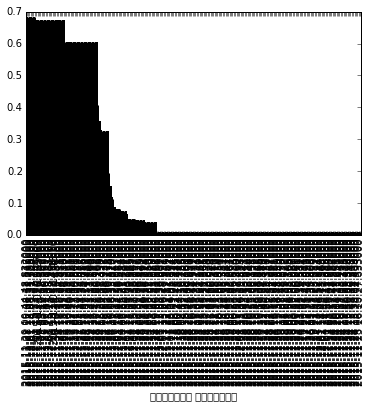

In [61]:
pheta_i[pheta_i>0.6].plot(kind='bar')
pheta_i.head(10)

In [12]:
#Константа для порогового значения, больше этого значения анкеты убираем
THRESHOLD1 = 0.65
FILTER1 = pheta_i[pheta_i>THRESHOLD1] # Фильтруем
print("Будет удалено {} записей".format(len(FILTER1)))

Будет удалено 28 записей


In [13]:
new_data1 = DATA1.drop(FILTER1.index) # создаем новые данные

In [14]:
#new_data1.to_excel("after_1_filter.xlsx") # сохраняем

##  2) Фильтр отсутствия данных групповой

In [15]:
DATA2 = data_packet.copy() # принимаем данные

In [16]:
# работа фильтра
pheta_i = ph.make_pheta_i(DATA2) # делаем массив pheta_i

In [17]:
# считаем необходимые для фильтра коэффициенты
Wr =  pheta_i.groupby(level=0).sum()/pheta_i.groupby(level=0).count()
ss_pheta = pheta_i.sum()
W_minus_r = (ss_pheta - pheta_i.groupby(level=0).sum()) / (N0 - pheta_i.groupby(level=0).count())
Vr = W_minus_r - Wr

Визуализируем

Packets
4   -0.089483
2   -0.086872
1    0.037610
3    0.049938
0    0.080504
dtype: float64

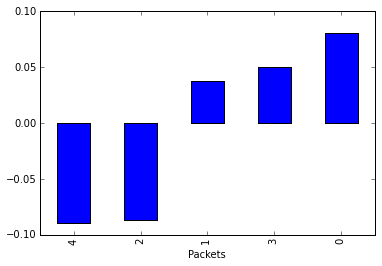

In [18]:
Vr.index.name = "Packets"
Vr.sort_values().plot(kind='bar')
Vr.sort_values().head()

In [19]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD2 = -0.01
FILTER2 = Vr[Vr < THRESHOLD2]
print("Будет удалено {} пакета(ов)".format(len(FILTER2)))

Будет удалено 2 пакета(ов)


In [20]:
new_data2 = DATA2.drop(FILTER2.index) # создаем новые данные

In [21]:
#new_data2.to_excel("after_2_filter.xlsx") # сохраняем

## 3) Фильтр экстремальных непрерывных значений

In [22]:
DATA3 = data_packet.copy() # принимаем данные

In [23]:
# работа фильтра
import lambd as lb
lambd = lb.make_lambd(DATA3, packets_num)
max_lambd = lambd == lambd.max()
Mu_i = max_lambd.sum(axis=1)

Визуализируем

Packets
0    10
1     6
3     5
2     3
4     1
dtype: int64

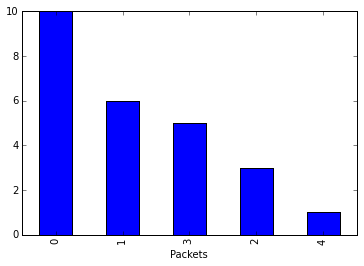

In [25]:
Mu_i = Mu_i.sort_values(ascending=False)
Mu_i.index.name = "Packets"
Mu_i.plot(kind='bar', x='packets')
Mu_i.head()

In [26]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD3 = 8

FILTER3 = Mu_i[Mu_i > THRESHOLD3]
print("Будет удалено {} пакета(ов)".format(len(FILTER3)))

Будет удалено 1 пакета(ов)


In [27]:
new_data3 = DATA3.drop(FILTER3.index) # создаем новые данные

In [28]:
#new_data3.to_excel("after_3_filter.xlsx") # сохраняем

## 4) Фильтр ранжирования непрерывных значений

In [35]:
DATA4 = data_packet.copy() # принимаем данные

Альтернативный алгоритм

In [208]:
X_r1 = DATA4.groupby(level=0).mean()
X_minus_r1=DATA4.groupby(level=0).apply(lambda row,group: DATA4.loc[DATA4.index.get_level_values(0) != group].mean(), 1)
lambd4 = X_minus_r1 - X_r1

Packets
0    90.0
2    84.5
3    72.0
1    65.0
4    63.5
dtype: float64

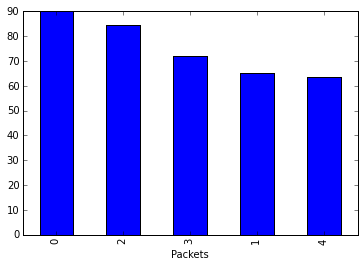

In [209]:
rank_lambd = lambd4.rank()
M_4 = rank_lambd.sum(axis=1)
M_4 = M_4.sort_values(ascending=False)
M_4.index.name = "Packets"
M_4.plot(kind='bar')
M_4.head()

Альтернатива кончилась

In [195]:
# работа фильтра
lambd4 = lb.make_lambd(DATA4, packets_num)
rank_lambd = lambd4.rank()
M_4 = rank_lambd.sum(axis=1)

Визуализируем

Packets
0    89.0
2    84.5
3    71.5
1    65.0
4    65.0
dtype: float64

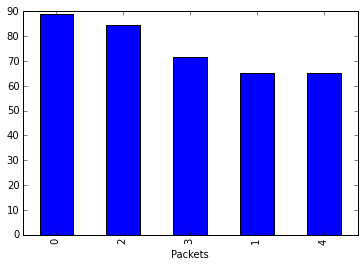

In [42]:
M_4 = M_4.sort_values(ascending=False)
M_4.index.name = "Packets"
M_4.plot(kind='bar')
M_4.head()

In [43]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD4 = 80

FILTER4 = M_4[M_4 > THRESHOLD4]
print("Будет удалено {} пакета(ов)".format(len(FILTER4)))

Будет удалено 2 пакета(ов)


In [47]:
new_data4 = DATA4.drop(FILTER4.index) # создаем новые данные

In [45]:
#new_data4.to_excel("after_4_filter.xlsx") # сохраняем

## 5) Фильтр метрический непрерывных значений

In [254]:
DATA5 = data_full.copy() # принимаем данные
#DATA5.apply(lambda row: row.name , axis=1)
X = DATA5.copy()
X_minus_i = DATA5.apply(lambda row: DATA5.loc[DATA5.index != row.name].mean() , axis=1)

Расстояние Евклида

In [217]:
# Расстояние Евклида
P_e = np.sqrt(np.square(X - X_minus_i).sum(1))
P_e = P_e.sort_values(ascending=False)

Packets
2015-11-24 16:12:54.851    62.303939
2015-11-29 11:02:35.022    61.854194
2015-11-29 01:54:58.565    61.472645
2015-11-29 12:08:48.359    58.731171
2015-11-29 12:37:35.778    57.787938
dtype: float64

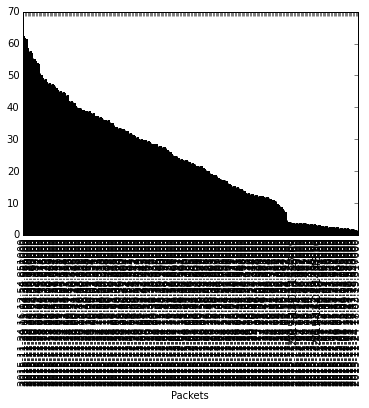

In [221]:
P_e[P_e>0].plot(kind='bar')
P_e.head()

In [225]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD5_1 = 60

FILTER5_1 = P_e[P_e > THRESHOLD5_1]
print("Будет удалено {} записей".format(len(FILTER5_1)))

Будет удалено 3 записей


In [226]:
new_data5_1 = DATA5.drop(FILTER5_1.index) # создаем новые данные
#new_data5_1.to_excel("after_5_1_filter.xlsx") # сохраняем

Расстояние Хэмминга

In [227]:
P_x = np.abs(X - X_minus_i).sum(1)
P_x = P_x.sort_values(ascending=False)

In [228]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD5_2 = 80

FILTER5_2 = P_x[P_x > THRESHOLD5_2]
print("Будет удалено {} записей".format(len(FILTER5_2)))

Будет удалено 25 записей


Отметка времени
2015-11-29 19:37:22.883    118.595241
2015-11-28 20:24:23.080    116.159175
2015-11-29 01:54:58.565    112.654400
2015-11-25 00:04:09.927    108.817996
2015-11-29 11:02:35.022    106.841584
dtype: float64

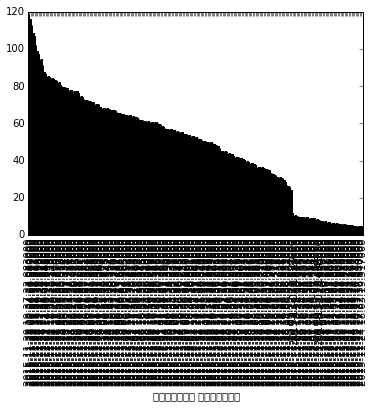

In [229]:
P_x[P_x>0].plot(kind='bar')
P_x.head()

In [257]:
new_data5_2 = DATA5.drop(FILTER5_2.index) # создаем новые данные
#new_data5_2.to_excel("after_5_2_filter.xlsx") # сохраняем

Кого-то там

In [267]:
#X.iloc[0] - X_minus_i.iloc[0]
X_minus_i.apply(lambda row: X.loc[X.index == row.name], axis=1)

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:1031: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._try_coerce_result(func(values, other))


ValueError: cannot copy sequence with size 25 to array axis with dimension 1

## 6) Фильтр частот кодирования

In [76]:
DATA6 = data_packet.copy() # принимаем данные

In [ ]:
# работа фильтра

#for col in DATA7:
#    val_frequency = dict(DATA7[col].value_counts())
#    A[col] = DATA7[col].map(val_frequency)

## 7) Фильтр замены кодированных значений

In [53]:
DATA7 = data_packet.copy() # принимаем данные

In [54]:
# работа фильтра
A = pd.DataFrame()
for col in DATA7:
    val_frequency = dict(DATA7[col].value_counts())
    A[col] = DATA7[col].map(val_frequency)
A = A/len(A.index)
A = A.sum(axis=1)

Визуализируем

   Отметка времени        
0  2015-11-24 17:41:49.870    9.159836
2  2015-11-17 22:55:49.975    9.098361
1  2015-11-29 09:50:01.983    8.750000
0  2015-11-24 16:58:34.352    8.733607
2  2015-11-18 06:44:33.302    8.627049
dtype: float64

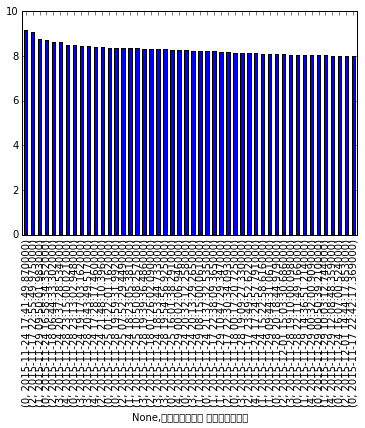

In [65]:
A = A.sort_values(ascending=False)
A[A>8].plot(kind='bar')
A[A>8].head()

In [71]:
#Константа для порогового значения, ниже этого значения анкеты убираем
THRESHOLD7 = 8

FILTER7 = A[A > THRESHOLD7]
print("Будет удалено {} записей".format(len(FILTER7)))

Будет удалено 48 записей


In [74]:
new_data7 = DATA7.drop(FILTER7.index) # создаем новые данные

In [75]:
#new_data7.to_excel("after_7_filter.xlsx") # сохраняем